# Shape From Shading 

## Step 0: Load the Data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
%matplotlib inline
#number of ALL images 
num_all = 500
num_train = 450
num_test = 50

#import ALL color images 
color_dir = "train/color/"
color = []
for i in range(4500,5000):
    img = cv2.imread(color_dir + str(i) + ".png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resize image
    #img = cv2.resize(img,(32, 32))
    color.append(img)
color = np.asarray(color)

#import train masks
mask_dir = "train/mask/"
mask = []
for i in range(4500,5000):
    img = cv2.imread(mask_dir + str(i) + ".png")
    #resize image
    #img = cv2.resize(img,(32, 32))
    mask.append(img)
mask = np.asarray(mask)

#import train normal
normal_dir = "train/normal/"
normal = []
for i in range(4500,5000):
    img = cv2.imread(normal_dir + str(i) + ".png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resize image
    #img = cv2.resize(img,(32, 32))
    normal.append(img)
normal = np.asarray(normal)

#train set 
train_color = color[0:num_train]
train_mask = mask[0:num_train]
train_normal = normal[0:num_train]

#test set 
test_color = color[num_train:num_all]
test_mask = mask[num_train:num_all]
test_normal = normal[num_train:num_all]


#print dimentions 
print(color.shape)
print(mask.shape)
print(normal.shape)

(500, 128, 128, 3)
(500, 128, 128, 3)
(500, 128, 128, 3)


## Step 1: import VGG16 Model

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=True)

## Step 2: extract hypercolumns

import scipy as sp
from keras import backend as K


def extract_hypercolumn(model, layer_indexes, instance):
    layers = [model.layers[li].output for li in layer_indexes]
    get_features = K.function([model.layers[0].input, K.learning_phase()], layers)
    
    feature_maps = get_features([instance,0])
    hypercolumns = []
    for convmap in feature_maps:
        hc = []
        for fmap in convmap[0]:
            #fmap = sp.misc.imresize(fmap, size=(224, 224), mode="F", interp='bilinear')
            #hypercolumns.append(fmap)
            hc.append(fmap)
        hc = np.average(hc, axis=2)
        #hc = cv2.resize(hc,(128, 128))
        hc = sp.misc.imresize(hc, size=(128, 128), mode="F", interp='bilinear')
        hypercolumns.append(hc)
    return np.asarray(hypercolumns)


### Extract Hypercolumns

color_hc = []
layers_extract = [1,2,4,5,7,8,9,11,12,13,15,16,17]
#count = 0
for col in color:
    #if np.mod(count,100) == 0:
    #    print(count)
    #count = count + 1
    temp = cv2.resize(col, (224, 224))
    temp = image.img_to_array(temp)
    temp = np.expand_dims(temp, axis=0)
    hc = extract_hypercolumn(model, layers_extract, temp)
    color_hc.append(hc)
color_hc = np.asarray(color_hc)
print(color_hc.shape)

In [15]:
import numpy as np
color_hc = np.load("a5000.npy")


(500, 13, 128, 128)


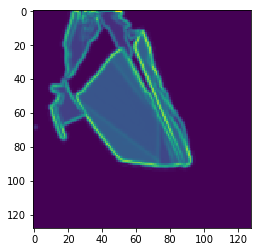

In [16]:
print(color_hc.shape)
plt.imshow(color_hc[-1][0])

In [6]:
num_all = 500
num_train = 450
num_test = 50

### Reshape hypercolumns: [None,13,128,128] => [None,128,128,13]

(500, 128, 128, 13)


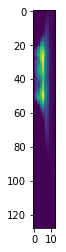

In [17]:
#reshape: [13,128,128] => [128,128,13]
color_hc_temp = []
for i in range(num_all):
    temp = np.zeros((128,128,13))
    for j in range(13):
        temp[:,:,j] = color_hc[i,j,:,:]
    color_hc_temp.append(temp)
color_hc_temp = np.asarray(color_hc_temp)    
color_hc = color_hc_temp
print(color_hc.shape)


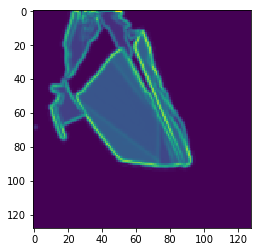

In [18]:
plt.imshow(color_hc[-1,:,:,0])

In [5]:
train_color_hc = color_hc[0:num_train]
test_color_hc = color_hc[num_train:num_all]
print(train_color_hc.shape)
print(test_color_hc.shape)

(450, 128, 128, 13)
(50, 128, 128, 13)


## Step 3: Preprocess training Image 

In [6]:
X_train = []
X_train_masked = []
y_train_masked = []
hc_subset = [8]
for i in range(num_train):
    for j in range(128):
        for k in range(128):
            temp = []
            for l in range(len(hc_subset)):
                temp.append(train_color_hc[i,j,k,hc_subset[l]])
            X_train.append(temp)
            if train_mask[i,j,k,1] > 0:
                tempX = []
                tempy = []
                for l in range(len(hc_subset)):
                    tempX.append(train_color_hc[i,j,k,hc_subset[l]])
                for l in range(3):
                    tempy.append(train_normal[i,j,k,l])
                X_train_masked.append(tempX)
                y_train_masked.append(tempy)
                
X_train = np.asarray(X_train)               
X_train_masked = np.asarray(X_train_masked)
y_train_masked = np.asarray(y_train_masked)

X_train = ((X_train / 255.0) - 0.5) * 2
X_train_masked = ((X_train_masked / 255.0) - 0.5) * 2
y_train_masked = ((y_train_masked / 255.0) - 0.5) * 2


print(X_train.shape)
print(X_train_masked.shape)
print(y_train_masked.shape)

(7372800, 1)
(2481178, 1)
(2481178, 3)


## Step 4: Build Regression Model

In [7]:
import tensorflow as tf
# tf Graph Input

# Parameters
learning_rate = 0.001
training_epochs = 5000
n_samples = X_train_masked.shape[0]
display_step = 100


X = tf.placeholder(tf.float32,(None,len(hc_subset)))
Y = tf.placeholder(tf.float32,(None,3))
# Set model weights
W1 = tf.Variable(tf.truncated_normal(shape = (len(hc_subset),3), name = "weight1"))
b1 = tf.Variable(tf.zeros(3), name = 'bias1')

#W = tf.Variable(rng.randn(), name="weight")
#b = tf.Variable(rng.randn(), name="bias")
# Construct a linear model



In [8]:
pred = tf.add(tf.matmul(X, W1), b1)
# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2)) / (2*n_samples)
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

saver = tf.train.Saver()

### Launch the graph

In [9]:
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        #for (x, y) in zip(X_train, y_train):
        #    x = np.reshape(x, [1,5])
        #    y = np.reshape(y, [1,3])
        sess.run(optimizer, feed_dict={X: X_train_masked, Y: y_train_masked})

        #Display epoch step
        if epoch % display_step == 0:
            c = sess.run(cost, feed_dict={X: X_train_masked, Y:y_train_masked})
            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: X_train_masked, Y: y_train_masked})
    print ("Training cost=", training_cost, "W1=", sess.run(W1), "b1=", sess.run(b1), '\n')
    print(hc_subset)
    saver.save(sess, './iiinet')
    print("Model saved")


Epoch: 0000 cost= 0.844601929
Epoch: 0100 cost= 0.712114811
Epoch: 0200 cost= 0.612322688
Epoch: 0300 cost= 0.537149668
Epoch: 0400 cost= 0.480527937
Epoch: 0500 cost= 0.437868327
Epoch: 0600 cost= 0.405723304
Epoch: 0700 cost= 0.381497025
Epoch: 0800 cost= 0.363236487
Epoch: 0900 cost= 0.349471062
Epoch: 1000 cost= 0.339085996
Epoch: 1100 cost= 0.331257373
Epoch: 1200 cost= 0.325346172
Epoch: 1300 cost= 0.320881426
Epoch: 1400 cost= 0.317508012
Epoch: 1500 cost= 0.314952523
Epoch: 1600 cost= 0.313013881
Epoch: 1700 cost= 0.311538368
Epoch: 1800 cost= 0.310415894
Epoch: 1900 cost= 0.309556484
Epoch: 2000 cost= 0.308898538
Epoch: 2100 cost= 0.308390170
Epoch: 2200 cost= 0.307993919
Epoch: 2300 cost= 0.307684660
Epoch: 2400 cost= 0.307437122
Epoch: 2500 cost= 0.307238102
Epoch: 2600 cost= 0.307075739
Epoch: 2700 cost= 0.306941658
Epoch: 2800 cost= 0.306826115
Epoch: 2900 cost= 0.306728333
Epoch: 3000 cost= 0.306639642
Epoch: 3100 cost= 0.306563795
Epoch: 3200 cost= 0.306493372
Epoch: 330

## Step 5: Use Trained Regression Model to Predict Test Image  

### Preprocess Test Image

In [10]:
X_test = []

for i in range(num_test):
    for j in range(128):
        for k in range(128):
            temp = []
            for l in range(len(hc_subset)):
                temp.append(test_color_hc[i,j,k,hc_subset[l]])
            X_test.append(temp)
                
X_test = np.asarray(X_test)
X_test = ((X_test / 255.0) - 0.5) * 2
print(X_test.shape)

(819200, 1)


In [11]:
with tf.Session() as sess: 
    saver.restore(sess, tf.train.latest_checkpoint('.')) 
    output = sess.run(pred, feed_dict={X: X_test})

### Rocover Predicted Test Image 

In [12]:
pred_normal = np.reshape(output,(num_test, 128,128,3))
pred_normal = (pred_normal /2 + 0.5) * 255
pred_normal = np.round(pred_normal)
for i in range(num_test):
    for j in range(128):
        for k in range(128):
            if test_mask[i,j,k,0] == 0:
                pred_normal[i,j,k,:] = 0
print(pred_normal.shape)

(50, 128, 128, 3)


### Visualize Test Image 

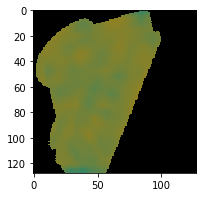

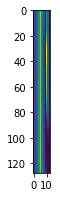

In [18]:
plt.figure(figsize = (3,3))
plt.imshow(pred_normal[3])
plt.figure(figsize = (3,3))
plt.imshow(test_normal[3])


In [14]:
import scipy.misc
for i in range(len(pred_normal)):
    scipy.misc.imsave(str(i+4950)+'.png', pred_normal[i])
    